In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.optim import Adam
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import tensorflow as tf
import math
from torch.utils.data import TensorDataset, DataLoader

# 시드 고정
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

set_seed(42)

In [2]:
data = pd.read_csv('/home/aibig25/hong_sj/trb/num.csv')
data = data.fillna(0)

unique_ids = data['sequence_ID'].unique()
train_ids, test_ids = train_test_split(unique_ids, test_size=41, random_state=42)
train_data = data[data['sequence_ID'].isin(train_ids)]
test_data = data[data['sequence_ID'].isin(test_ids)]

independent_vars = data.columns.difference(['center_x', 'center_y','center_x_ma','center_y_ma', 'ID', 'LC'])
dependent_vars = ['center_y_ma']

scaler = MinMaxScaler()

train_data[independent_vars] = scaler.fit_transform(train_data[independent_vars])
test_data[independent_vars] = scaler.transform(test_data[independent_vars])

X_train = train_data[independent_vars]
y_train = train_data[dependent_vars]

X_test = test_data[independent_vars]
y_test = test_data[dependent_vars]

/tmp/ipykernel_123494/3224682186.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[independent_vars] = scaler.fit_transform(train_data[independent_vars])
/tmp/ipykernel_123494/3224682186.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[independent_vars] = scaler.transform(test_data[independent_vars])


In [3]:
# 입력 및 예측 시퀀스 길이 정의
input_sequence_length = 30
output_sequence_length = 30

In [14]:
# 차량 ID 및 파라미터 설정
sequence_id = 71

# sequence_ID에 해당하는 데이터 필터링 및 스케일링
vehicle_data = data[data['sequence_ID'] == sequence_id].copy()
vehicle_data[independent_vars] = scaler.transform(vehicle_data[independent_vars])
total_frames = len(vehicle_data)

# input_sequence_length와 output_sequence_length를 적용하여 데이터 전처리
def create_sequences_for_vehicle(vehicle_data, input_sequence_length, output_sequence_length):
    X = []
    y = []
    
    # 마지막 시퀀스까지 처리할 수 있도록 수정
    for i in range(len(vehicle_data) - input_sequence_length + 1):
        X.append(vehicle_data.iloc[i:(i + input_sequence_length)][independent_vars].values)
        if i + input_sequence_length + output_sequence_length <= len(vehicle_data):
            y.append(vehicle_data.iloc[(i + input_sequence_length):(i + input_sequence_length + output_sequence_length)][dependent_vars].values)
        else:
            # 마지막 시퀀스가 output_sequence_length보다 짧으면 0으로 패딩
            remaining_length = len(vehicle_data) - (i + input_sequence_length)
            last_sequence = vehicle_data.iloc[(i + input_sequence_length):][dependent_vars].values
            padded_sequence = np.pad(last_sequence, ((0, output_sequence_length - remaining_length), (0, 0)), mode='constant')
            y.append(padded_sequence)
    
    return np.array(X), np.array(y)

X_vehicle, y_vehicle = create_sequences_for_vehicle(vehicle_data, input_sequence_length, output_sequence_length)

# 데이터셋을 텐서로 변환
vehicle_dataset = TensorDataset(torch.tensor(X_vehicle, dtype=torch.float32), torch.tensor(y_vehicle, dtype=torch.float32))
vehicle_loader = DataLoader(vehicle_dataset, batch_size=10, shuffle=False)

In [18]:
class TrajectoryTransformer(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_encoder_layers, num_decoder_layers, output_dim):
        super(TrajectoryTransformer, self).__init__()
        self.model_dim = model_dim
        
        self.encoder = nn.Linear(input_dim, model_dim)
        self.pos_encoder = PositionalEncoding(model_dim)
        self.tgt_linear = nn.Linear(1, model_dim)  # tgt 차원 변환용 Linear 계층
        
        self.transformer = nn.Transformer(
            d_model=model_dim,
            nhead=num_heads,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=model_dim * 4,
            dropout=0.1
        )
        
        self.decoder = nn.Linear(model_dim, output_dim)

    def forward(self, src, tgt):
        src = self.encoder(src)
        src = src * math.sqrt(self.model_dim)
        src = self.pos_encoder(src.permute(1, 0, 2))

        tgt = tgt.squeeze(-1)  # 마지막 차원 제거
        original_shape = tgt.shape
        tgt = tgt.reshape(-1, 1)  # view 대신 reshape 사용 (batch_size * seq_length, 1)
        tgt = self.tgt_linear(tgt)  # 차원 조정
        tgt = tgt.view(original_shape[0], original_shape[1], -1)  # 원래 차원으로 복원
        tgt = tgt * math.sqrt(self.model_dim)
        tgt = self.pos_encoder(tgt.permute(1, 0, 2))

        output = self.transformer(src, tgt)
        output = self.decoder(output.permute(1, 0, 2))

        return output


# 위치 인코딩 추가
class PositionalEncoding(nn.Module):
    def __init__(self, model_dim, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.encoding = torch.zeros(max_len, model_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, model_dim, 2).float() * (-math.log(10000.0) / model_dim))
        self.encoding[:, 0::2] = torch.sin(position * div_term)
        self.encoding[:, 1::2] = torch.cos(position * div_term)
        self.encoding = self.encoding.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', self.encoding)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return x

In [19]:
# 모델 초기화
input_dim = len(independent_vars)
output_dim = len(dependent_vars)
model_dim = 512
num_heads = 4
num_encoder_layers = 3
num_decoder_layers = 3

model = TrajectoryTransformer(input_dim, model_dim, num_heads, num_encoder_layers, num_decoder_layers, output_dim)

# 옵티마이저와 손실 함수
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [20]:
# 모델 초기화 및 가중치 로드
model.load_state_dict(torch.load('/home/aibig25/hong_sj/trb/transformer/old/old_transformer_1_1.pth'))

# 모델을 평가 모드로 설정
model.eval()

TrajectoryTransformer(
  (encoder): Linear(in_features=26, out_features=512, bias=True)
  (pos_encoder): PositionalEncoding()
  (tgt_linear): Linear(in_features=1, out_features=512, bias=True)
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-2): 3 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
          )
          (linear1): Linear(in_features=512, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=512, bias=True)
          (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((512,), eps=1e-05, e

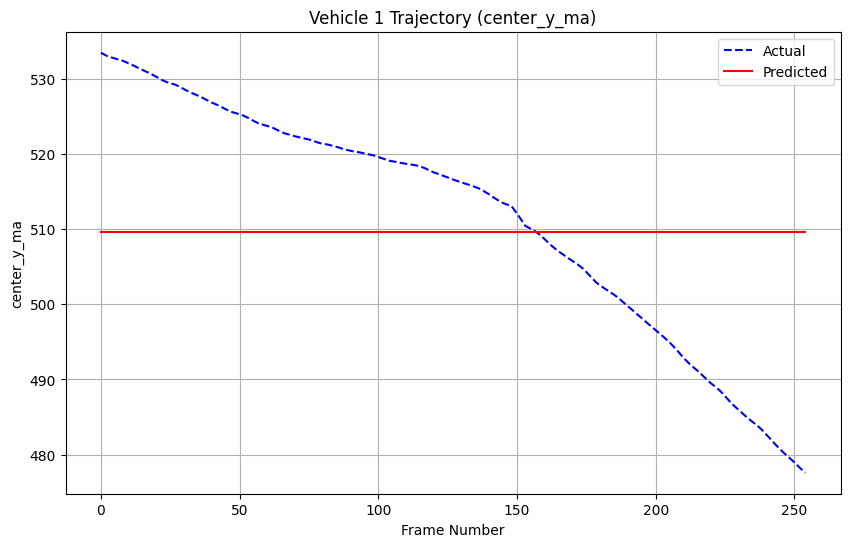

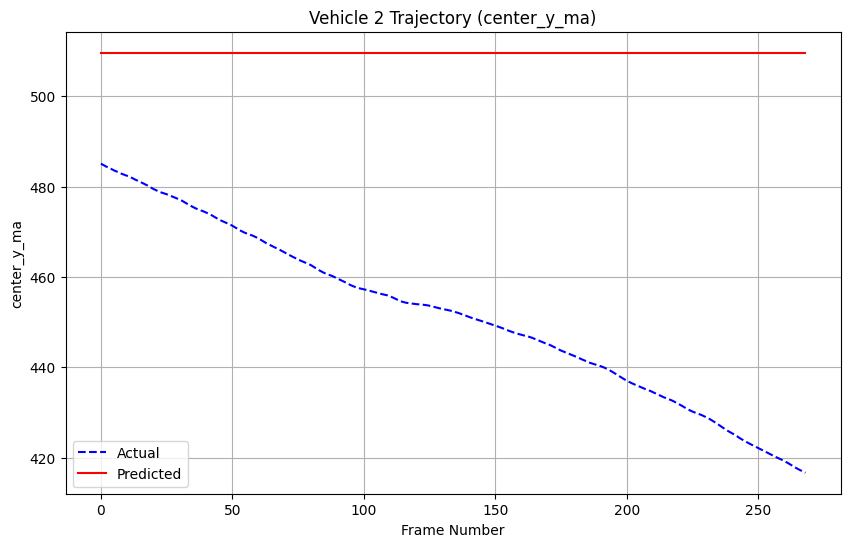

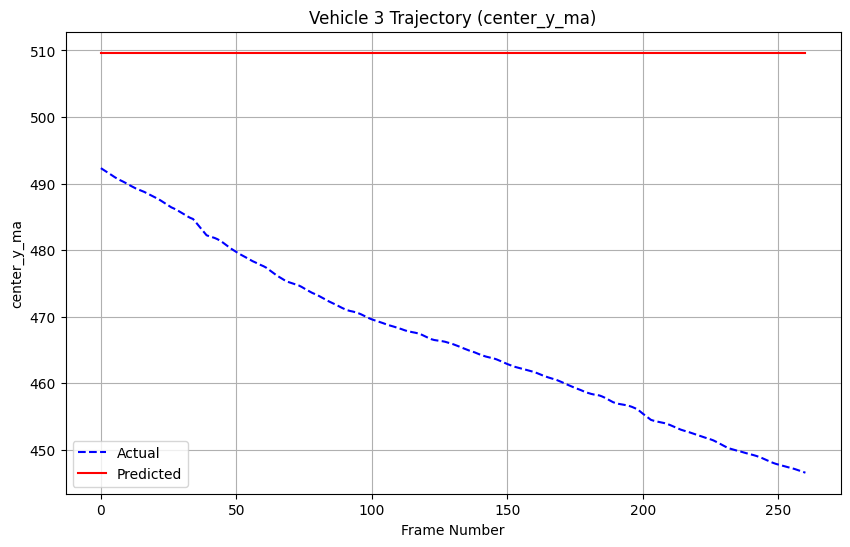

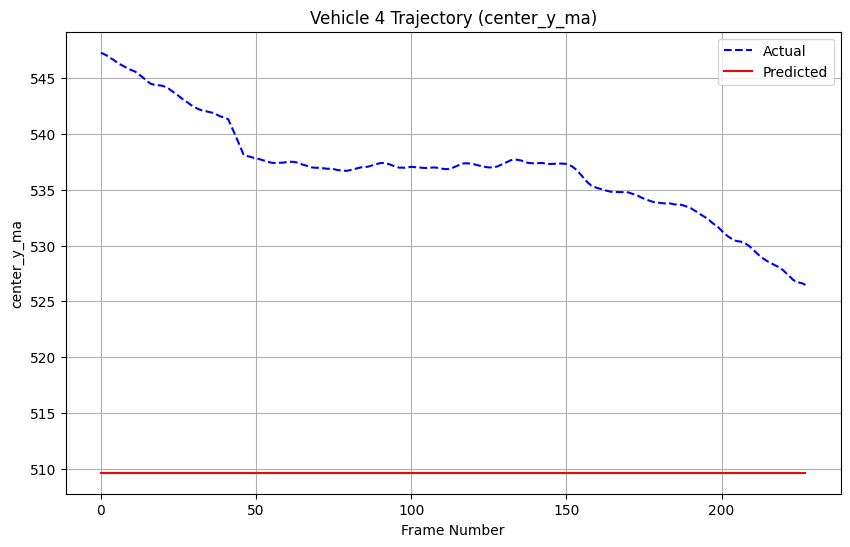

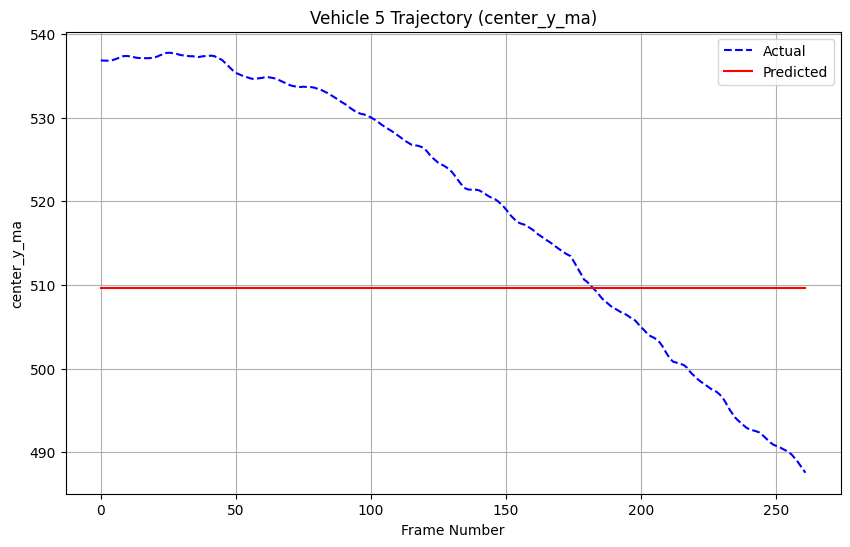

KeyboardInterrupt: 

In [22]:
# 중복된 출력값을 평균 처리하는 함수
def average_overlapping_predictions(predictions, input_sequence_length, output_sequence_length, total_frames):
    # 중복이 발생하는 구간을 평균으로 처리할 배열 생성
    averaged_predictions = np.zeros((total_frames - input_sequence_length, predictions.shape[2]))
    count = np.zeros(total_frames - input_sequence_length)  # 각 프레임에 대해 몇 번의 예측이 있었는지 카운트
    
    for i in range(len(predictions)):
        for j in range(output_sequence_length):
            if i + j < len(averaged_predictions):
                averaged_predictions[i + j] += predictions[i, j]
                count[i + j] += 1
    
    # 평균 계산
    averaged_predictions = averaged_predictions / count[:, np.newaxis]
    
    return averaged_predictions

# 시각화 함수 수정: x축은 프레임 번호, y축은 center_y_ma
def plot_trajectory(predictions, actuals, vehicle_id):
    plt.figure(figsize=(10, 6))
    
    # 프레임 번호 생성 (예측 프레임 번호는 처음 30프레임 제외)
    frames = np.arange(len(predictions))
    
    # 실제 값 시각화 (center_y_ma 값만 시각화)
    plt.plot(frames, actuals, label="Actual", color="blue", linestyle='--')
    
    # 예측 값 시각화 (center_y_ma 값만 시각화)
    plt.plot(frames, predictions, label="Predicted", color="red")
    
    plt.title(f'Vehicle {vehicle_id} Trajectory (center_y_ma)')
    plt.xlabel('Frame Number')
    plt.ylabel('center_y_ma')
    plt.legend()
    plt.grid(True)
    plt.show()

# 차량별 데이터 예측 및 시각화
for sequence_id in unique_ids:
    vehicle_data = data[data['sequence_ID'] == sequence_id].copy()
    vehicle_data[independent_vars] = scaler.transform(vehicle_data[independent_vars])
    total_frames = len(vehicle_data)

    # 시퀀스 생성
    X_vehicle, y_vehicle = create_sequences_for_vehicle(vehicle_data, input_sequence_length, output_sequence_length)

    vehicle_dataset = TensorDataset(torch.tensor(X_vehicle, dtype=torch.float32), torch.tensor(y_vehicle, dtype=torch.float32))
    vehicle_loader = DataLoader(vehicle_dataset, batch_size=10, shuffle=False)

    # 모델 예측
    all_predictions = []
    all_actuals = []

    with torch.no_grad():
        for X_batch, y_batch in vehicle_loader:
            X_batch = X_batch.permute(1, 0, 2)  # Transformer의 입력 형식에 맞게 차원 변환
            y_batch = y_batch.permute(1, 0, 2)  # Transformer의 출력 형식에 맞게 차원 변환

            predicted_batch = model(X_batch, y_batch)
            all_predictions.append(predicted_batch.permute(1, 0, 2).cpu().numpy())  # 차원 다시 변환 후 numpy로 변환
            all_actuals.append(y_batch.permute(1, 0, 2).cpu().numpy())

    all_predictions = np.concatenate(all_predictions, axis=0)
    all_actuals = np.concatenate(all_actuals, axis=0)

    # 처음 30프레임 제외한 후 중복값 평균 처리
    averaged_predictions = average_overlapping_predictions(all_predictions, input_sequence_length, output_sequence_length, total_frames)

    # 실제 값도 처음 30프레임을 제외, center_y_ma 값만 추출
    actuals_excluding_first = vehicle_data['center_y_ma'].values[input_sequence_length:]

    # 궤적 시각화 (x축: 프레임 번호, y축: center_y_ma)
    plot_trajectory(averaged_predictions[:, 0], actuals_excluding_first, sequence_id)